In [1]:
from PIL import Image
import os, glob, numpy as np
from sklearn.model_selection import train_test_split

caltech_dir = "./skin_train_data"
categories = ["cancer", "wound", "atopi"]
nb_classes = len(categories)

image_w = 64
image_h = 64

pixels = image_h * image_w * 3

X = []
y = []

for idx, cat in enumerate(categories):
    
    #one-hot 인코딩
    label = [0 for i in range(nb_classes)]
    label[idx] = 1
    print(str(label))

    image_dir = caltech_dir + "/" + cat
    files = glob.glob(image_dir+"/*.jpg")
    print(cat, " 파일 길이 : ", len(files))
    for i, f in enumerate(files):
        img = Image.open(f)
        img = img.convert("RGB")
        img = img.resize((image_w, image_h))
        data = np.asarray(img)

        X.append(data)
        y.append(label)

        if i % 700 == 0:
            print(cat, " : ", f)

X = np.array(X)
y = np.array(y)



X_train, X_test, y_train, y_test = train_test_split(X, y)
xy = (X_train, X_test, y_train, y_test)
np.save("./skin_train_data/numpy/skin_numpy.npy", xy)

print("ok", len(y))


[1, 0, 0]
cancer  파일 길이 :  2037
cancer  :  ./skin_train_data/cancer\ISIC_0024306.jpg
cancer  :  ./skin_train_data/cancer\ISIC_0025006.jpg
cancer  :  ./skin_train_data/cancer\ISIC_0025706.jpg
[0, 1, 0]
wound  파일 길이 :  3502
wound  :  ./skin_train_data/wound\_0_1001.jpg
wound  :  ./skin_train_data/wound\_0_2775.jpg
wound  :  ./skin_train_data/wound\_0_4481.jpg
wound  :  ./skin_train_data/wound\_0_6274.jpg
wound  :  ./skin_train_data/wound\_0_8131.jpg


이제 numpy 데이터를 불러온다. 저것을 가지고 학습!

In [ ]:
import os, glob, numpy as np
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
import tensorflow.python.keras.backend as K

import tensorflow as tf
config = tf.compat.v1.ConfigProto() 
config.gpu_options.allow_growth = True
session = tf.compat.v1.Session(config=config)

np_load_old = np.load
np.load = lambda *a,**k: np_load_old(*a, allow_pickle=True)
X_train, X_test, y_train, y_test = np.load('./skin_train_data/numpy/skin_numpy.npy')
np.load = np_load_old

print(X_train.shape)
print(X_train.shape[0])

(5910, 64, 64, 3)
5910


In [ ]:
categories = ["cancer", "wound", "atopi"]
nb_classes = len(categories)

#일반화
X_train = X_train.astype(float) / 255
X_test = X_test.astype(float) / 255

In [ ]:
model = Sequential()
model.add(Conv2D(32, (3,3), padding="same", input_shape=X_train.shape[1:], activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3,3), padding="same", activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(nb_classes, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model_dir = './model'

if not os.path.exists(model_dir):
    os.mkdir(model_dir)

model_path = 'skin_img_classification.h5'
checkpoint = ModelCheckpoint(filepath=model_path , monitor='val_loss', verbose=1, save_best_only=True)
early_stopping = EarlyStopping(monitor='val_loss', patience=6)



In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 64, 64, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 32, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 16, 16, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 16384)             0

In [ ]:

history = model.fit(X_train, y_train, batch_size=16, epochs=100, validation_split=0.25, callbacks=[checkpoint, early_stopping])

Epoch 1/100
277/277 [==============================] - 21s 72ms/step - loss: 0.6933 - accuracy: 0.6988 - val_loss: 0.3032 - val_accuracy: 0.9026

Epoch 00001: val_loss improved from inf to 0.30325, saving model to skin_img_classification.h5
Epoch 2/100
277/277 [==============================] - 20s 72ms/step - loss: 0.3407 - accuracy: 0.8773 - val_loss: 0.2248 - val_accuracy: 0.9290

Epoch 00002: val_loss improved from 0.30325 to 0.22483, saving model to skin_img_classification.h5
Epoch 3/100
277/277 [==============================] - 19s 68ms/step - loss: 0.2679 - accuracy: 0.9023 - val_loss: 0.2059 - val_accuracy: 0.9263

Epoch 00003: val_loss improved from 0.22483 to 0.20593, saving model to skin_img_classification.h5
Epoch 4/100
277/277 [==============================] - 19s 68ms/step - loss: 0.2149 - accuracy: 0.9251 - val_loss: 0.1589 - val_accuracy: 0.9445

Epoch 00004: val_loss improved from 0.20593 to 0.15891, saving model to skin_img_classification.h5
Epoch 5/100
277/277 [===

In [ ]:
print("정확도 : %.4f" % (model.evaluate(X_test, y_test)[1]))

62/62 [==============================] - 2s 37ms/step - loss: 0.0440 - accuracy: 0.9914
정확도 : 0.9914


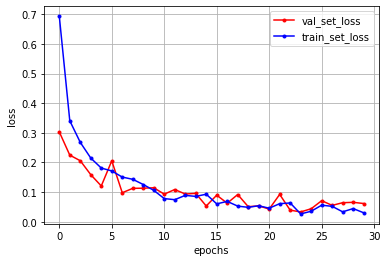

In [ ]:
y_vloss = history.history['val_loss']
y_loss = history.history['loss']

x_len = np.arange(len(y_loss))

plt.plot(x_len, y_vloss, marker='.', c='red', label='val_set_loss')
plt.plot(x_len, y_loss, marker='.', c='blue', label='train_set_loss')
plt.legend()
plt.xlabel('epochs')
plt.ylabel('loss')
plt.grid()
plt.show()

In [ ]:
from PIL import Image
import os, glob, numpy as np
from keras.models import load_model

caltech_dir = "./skin_train_data/test_img"
image_w = 64
image_h = 64

pixels = image_h * image_w * 3

X = []
filenames = []
files = glob.glob(caltech_dir+"/*.*")
for i, f in enumerate(files):
    img = Image.open(f)
    img = img.convert("RGB")
    img = img.resize((image_w, image_h))
    data = np.asarray(img)
    filenames.append(f)
    X.append(data)

X = np.array(X)
#print(str(X))
model = load_model('skin_img_classification.h5')

prediction = model.predict(X)
np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)})
cnt = 0

for i in prediction:
    pre_ans = i.argmax()  # 예측 레이블
    print(i)
    print(pre_ans)
    pre_ans_str = ''
    if pre_ans == 0: pre_ans_str = "피부암"
    else: pre_ans_str = "상처"
    if i[0] >= 0.8 : print(filenames[cnt].split("\\")[1]+"이미지: "+pre_ans_str+"(으)로 추정됨.")
    if i[1] >= 0.8: print(filenames[cnt].split("\\")[1]+"이미지: "+pre_ans_str+"(으)로 추정됨.")
    cnt += 1
    # print(i.argmax()) #얘가 레이블 [1. 0. 0.] 이런식으로 되어 있는 것을 숫자로 바꿔주는 것.
    # 즉 얘랑, 나중에 카테고리 데이터 불러와서 카테고리랑 비교를 해서 같으면 맞는거고, 아니면 틀린거로 취급하면 됨


[0.000 1.000 0.000]
1
cancertest.png이미지: 상처(으)로 추정됨.
[1.000 0.000 0.000]
0
ISIC_0029327.jpg이미지: 피부암(으)로 추정됨.
[0.000 1.000 0.000]
1
woundtest.jpg.png이미지: 상처(으)로 추정됨.
[0.000 1.000 0.000]
1
woundtest2.png이미지: 상처(으)로 추정됨.
